# Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the Regression Decision Tree Class

In [2]:
class RegressionDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        """
        Initialize the Regression Decision Tree.
        Parameters:
        - max_depth: Maximum depth of the tree (int, optional)
        - min_samples_split: Minimum number of samples required to split (int)
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def _mse(self, groups):
        """Calculate the Mean Squared Error for a split."""
        mse = 0.0
        for group in groups:
            if len(group) == 0:
                continue
            target = group[:, -1]
            mean = np.mean(target)
            mse += np.sum((target - mean) ** 2)
        return mse

    def _split(self, index, value, dataset):
        """Split a dataset into left and right groups."""
        left, right = [], []
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return np.array(left), np.array(right)

    def _best_split(self, dataset):
        """Find the best split based on MSE."""
        best_index, best_value, best_score, best_groups = None, None, float("inf"), None
        for index in range(dataset.shape[1] - 1):  # Exclude target column
            for row in dataset:
                groups = self._split(index, row[index], dataset)
                if any(len(group) == 0 for group in groups):
                    continue
                mse = self._mse(groups)
                if mse < best_score:
                    best_index, best_value, best_score, best_groups = index, row[index], mse, groups
        return {'index': best_index, 'value': best_value, 'groups': best_groups}

    def _to_terminal(self, group):
        """Create a terminal node with the mean of the target."""
        return np.mean(group[:, -1])

    def _split_node(self, node, depth):
        """Split the data or make terminal nodes."""
        left, right = node['groups']
        del node['groups']

        # Check for no split
        if not len(left) or not len(right):
            node['left'] = node['right'] = self._to_terminal(np.vstack((left, right)))
            return

        # Check for maximum depth
        if self.max_depth and depth >= self.max_depth:
            node['left'], node['right'] = self._to_terminal(left), self._to_terminal(right)
            return

        # Process left child
        if len(left) <= self.min_samples_split:
            node['left'] = self._to_terminal(left)
        else:
            node['left'] = self._best_split(left)
            self._split_node(node['left'], depth + 1)

        # Process right child
        if len(right) <= self.min_samples_split:
            node['right'] = self._to_terminal(right)
        else:
            node['right'] = self._best_split(right)
            self._split_node(node['right'], depth + 1)

    def fit(self, X, y):
        """Fit the Regression Tree to the dataset."""
        dataset = np.hstack((X, y.reshape(-1, 1)))
        self.tree = self._best_split(dataset)
        self._split_node(self.tree, 1)

    def _predict(self, node, row):
        """Make a prediction for a single sample."""
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self._predict(node['right'], row)
            else:
                return node['right']

    def predict(self, X):
        """Predict values for samples in X."""
        return np.array([self._predict(self.tree, row) for row in X])

# Generate Synthetic Regression Data

In [3]:
np.random.seed(42)
X = np.random.rand(200, 2) * 10  # 2 features
y = 2 * X[:, 0] + 3 * X[:, 1] + np.random.randn(200) * 2  # Linear trend with noise

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Regression Decision Tree

In [4]:
tree = RegressionDecisionTree(max_depth=5, min_samples_split=5)
tree.fit(X_train, y_train)

# Predict and Visualize Results

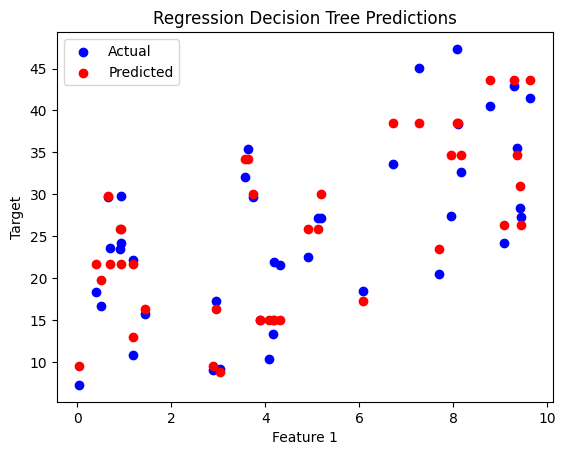

In [6]:
def plot_predictions(X, y_actual, y_pred):
    plt.scatter(X[:, 0], y_actual, color="blue", label="Actual")
    plt.scatter(X[:, 0], y_pred, color="red", label="Predicted")
    plt.title("Regression Decision Tree Predictions")
    plt.xlabel("Feature 1")
    plt.ylabel("Target")
    plt.legend()
    plt.show()
    
# Predict the target values for the test set
y_pred = tree.predict(X_test)
plot_predictions(X_test, y_test, y_pred)
